In [129]:
import numpy as np
import matplotlib.pyplot as plt

In [130]:
# weight transfer

mass = 250 #kg
cg_height = .3 #m
tw = 1.3 #m
wb = 1.525 #m
front_wb = .839 #m
back_wb = wb - front_wb #m

g = 9.81

def tire_loads(m, long_g, lat_g, cg_h, wheelbase, front_wb, track):

    back_wb = wheelbase - front_wb

    ax = long_g * g
    ay = lat_g * g

    # static axle loads
    front_static = m * g * back_wb / wheelbase
    rear_static  = m * g * front_wb / wheelbase

    # longitudinal
    dFx = m * ax * cg_h / wheelbase

    front_axle = front_static + dFx
    rear_axle  = rear_static  - dFx

    # lateral
    dFy_total = m * ay * cg_h / track

    # lateral distribution ASSUMPTION (reality would be based on suspension + chassis roll stiffness)
    front_frac = back_wb / wheelbase
    rear_frac  = front_wb / wheelbase

    dFy_front = dFy_total * front_frac
    dFy_rear  = dFy_total * rear_frac

    FR = front_axle / 2 + dFy_front / 2
    FL = front_axle / 2 - dFy_front / 2
    RR = rear_axle  / 2 + dFy_rear  / 2
    RL = rear_axle  / 2 - dFy_rear  / 2

    return FL, FR, RL, RR

Maximum Front Right Tire Load: 1042.57 N at 62.2°


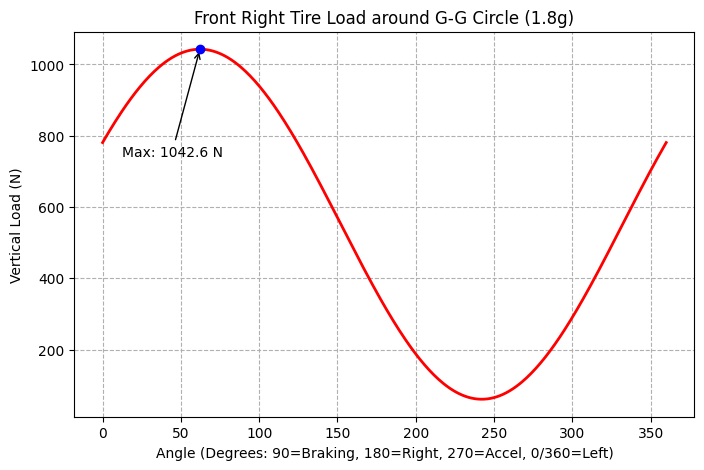

In [131]:
max_g = 1.8

# g-g circle
angles = np.linspace(0, 2 * np.pi, 360)  # 0 to 360 degrees
fr_loads = []

for theta in angles:
    lat_g = max_g * np.cos(theta)
    long_g = max_g * np.sin(theta)
    
    _,fr_load,_,_ = tire_loads(mass, long_g, lat_g, cg_height, wb, front_wb, tw)
    fr_loads.append(fr_load)

fr_loads_np = np.array(fr_loads)

# Find maximum load and its angle
max_load = fr_loads_np.max()
max_index = fr_loads_np.argmax()
max_angle_deg = np.degrees(angles[max_index])

print(f"Maximum Front Right Tire Load: {max_load:.2f} N at {max_angle_deg:.1f}°")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(np.degrees(angles), fr_loads, color='red', lw=2)
plt.title("Front Right Tire Load around G-G Circle (1.8g)")
plt.xlabel("Angle (Degrees: 90=Braking, 180=Right, 270=Accel, 0/360=Left)")
plt.ylabel("Vertical Load (N)")
plt.grid(True, linestyle='--')

# Annotate max load
plt.scatter(max_angle_deg, max_load, color='blue', zorder=5)
plt.annotate(f"Max: {max_load:.1f} N",
             xy=(max_angle_deg, max_load),
             xytext=(max_angle_deg -50, max_load -300),
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             fontsize=10)

plt.show()

In [132]:
# Points

# L or U lower or upper
# F or R front or rear
# c or o chassis or outboard

# lower front ca
LFc = np.array([0.255, -0.2216, 0])
LFo = np.array([0, -0.563 , -0.0016])

# lower rear ca
LRc = np.array([0.00146, -0.2216, 0])
LRo = LFo

# upper front ca
UFc = np.array([0.255, -0.26, 0.18])
UFo = np.array([-0.0255, -0.533 , 0.186])

# upper rear ca
URc = np.array([-0.0146, -0.26, 0.18])
URo = UFo

# pushrod
Pc = np.array([0.014, -0.235, 0.427])
Po = np.array([0.014, -0.525, 0.024])

# tie rod
Tc = np.array([0.104, -0.24, 0.073])
To = np.array([0.063, -0.59, 0.05])

# contact patch
CP = np.array([0, -0.614, -0.132])

In [133]:
def unit_vec(p1: np.array, p2: np.array):

    # from outboard to chassis
    # p1 = chassis 
    # p2 = upright/ outboard
    v = p1 - p2
    mag = np.linalg.norm(v)

    return v / mag

# lower front
LF = unit_vec(LFc, LFo)

# lower rear
LR = unit_vec(LRc, LRo)

# upper front
UF = unit_vec(UFc, UFo)

# upper rear
UR = unit_vec(URc, URo)

# pushrod
Pushrod = unit_vec(Pc, Po)

# tie rod
Tierod = unit_vec(Tc, To)

In [137]:
# moments are all r (from origin to upright point) x Force unit vector
LF_moment = np.cross(LFo, LF)
LR_moment = np.cross(LRo, LR)
UF_moment = np.cross(UFo, UF)
UR_moment = np.cross(URo, UR)
Pushrod_moment = np.cross(Po, Pushrod)
Tierod_moment = np.cross(To, Tierod)

#contact patch moments
#max_load is Fz
#positive Fx is accel, negative is brake
# positive Fy is right turn, negative is left turn

Fx  = max_load * 2.91 #2.91 is peak Fx/Fz
Fy = max_load * 2.99 #2.99 is peak Fy/Fz

F_tire = np.array([Fx, Fy, max_load])
M_tire = np.cross(CP, F_tire)

# Extract components for clarity if you prefer
Mx, My, Mz = M_tire[0], M_tire[1], M_tire[2]


In [138]:
forces_vectors = [LF, LR, UF, UR, Pushrod, Tierod]
forces_stack = np.stack(forces_vectors, axis=1)

moments_vectors = [LF_moment, LR_moment, UF_moment, UR_moment, Pushrod_moment, Tierod_moment]
moments_stack = np.stack(moments_vectors, axis=1)

fm_stack = [forces_stack, moments_stack]
fm_stack = np.vstack((forces_stack, moments_stack))

In [139]:
# solve for forces
# positive values are away from upright/ tension, negative is toward upright/ compression

forces = np.array([-Fx, -Fy, -max_load, -Mx, -My, -Mz])

member_forces = np.linalg.solve(fm_stack, forces)

labels = ["Lower Front", "Lower Rear", "Upper Front", "Upper Rear", "Pushrod", "Tie Rod"]
for label, force in zip(labels, member_forces):
    print(f"{label}: {force:.2f} N")

Lower Front: -8412.57 N
Lower Rear: 2901.08 N
Upper Front: 2863.75 N
Upper Rear: -70.80 N
Pushrod: -1167.81 N
Tie Rod: -527.35 N


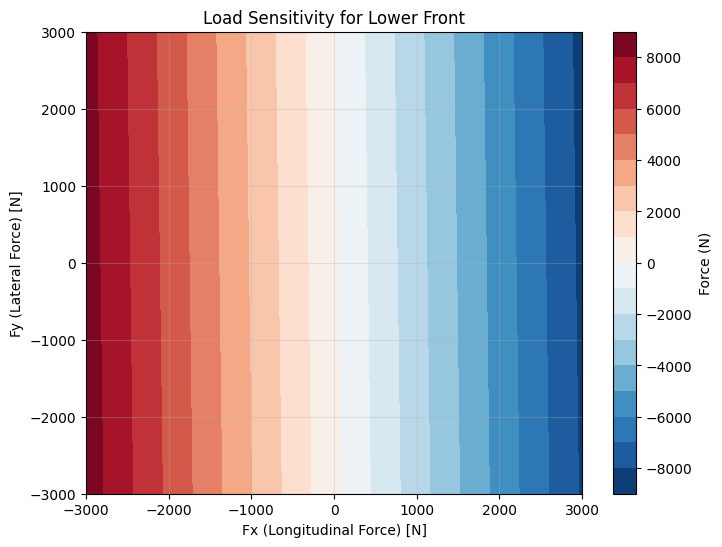

In [ ]:
# Define ranges for the sweep
fx_range = np.linspace(-3000, 3000, 13) 
fy_range = np.linspace(-3000, 3000, 13)

# Create a grid
FX, FY = np.meshgrid(fx_range, fy_range)
FX_flat = FX.flatten()
FY_flat = FY.flatten()

# Prepare the RHS (B) matrix: each column is a different load case
# Shape will be (6, N) where N is the number of combinations
B_sweep = np.zeros((6, len(FX_flat)))

for i in range(len(FX_flat)):
    f_ext = np.array([FX_flat[i], FY_flat[i], max_load])
    m_ext = np.cross(CP, f_ext)
    B_sweep[:, i] = np.concatenate([f_ext, m_ext])

# Solve all cases at once: A * X = -B_sweep
# member_forces_sweep shape: (6, N)
all_member_forces = np.linalg.solve(A, -B_sweep)

import matplotlib.pyplot as plt

# Choose a link to inspect (0: LF, 1: LR, 2: UF, 3: UR, 4: Push, 5: Tie)
link_idx = 0 
link_name = labels[link_idx]

# Reshape forces back to the grid shape for plotting
Z = all_member_forces[link_idx, :].reshape(FX.shape)

plt.figure(figsize=(8, 6))
cp = plt.contourf(FX, FY, Z, cmap='RdBu_r', levels=20)
plt.colorbar(cp, label='Force (N)')
plt.title(f'Load Sensitivity for {link_name}')
plt.xlabel('Fx (Longitudinal Force) [N]')
plt.ylabel('Fy (Lateral Force) [N]')
plt.grid(alpha=0.3)
plt.show()